This notebook implements fine-tuning of pre-trained [FracTAL ResUNet model](https://www.mdpi.com/2072-4292/13/11/2197) using monthly Planet RGB chunks and validation data. It also exports evaluation metrics and export fine-tuned model parameters.

## Load packages and modules

In [1]:
# !pip -q install mxnet

In [3]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import mxnet as mx
from mxnet import gluon
from mxnet import image
from glob import glob
# import imageio.v2 as imageio
from osgeo import gdal, osr
import sys
from multiprocessing import cpu_count

# add existing and decode modules to system path
module_paths=['decode/FracTAL_ResUNet/models/semanticsegmentation',
             'decode/FracTAL_ResUNet/nn/loss']
for module_path in module_paths:
    if module_path not in sys.path:
        sys.path.append(module_path)
# print(sys.path)

In [4]:
# import functions from modules
from FracTAL_ResUNet import FracTAL_ResUNet_cmtsk
from datasets import *
from ftnmt_loss import ftnmt_loss
from evaluation import dice_coef,train_model_per_epoch,evaluate_model_per_epoch

## Define parameters

In [5]:
# hyperparameters for model architecture or training
n_filters = 32
depth = 6
n_classes = 1
batch_size = 4
ctx_name = 'cpu'
gpu_id = 0
epochs = 20
lr = 0.0001
lr_decay = None

# other parameters
country = 'Rwanda'
str_month='03' # selected month in string format
CPU_COUNT = cpu_count()
srs = osr.SpatialReference()
srs.ImportFromEPSG(3857)

# input folder of input RGB chunk geotiffs
input_folder='../0_Data_preparation/results/RGB_chunks'
# input folder of groundtruth geotiffs
groundtruth_folder='../0_Data_preparation/results/groundtruth'
# output folder to store evaluation metrics
out_folder='metrics'

# input pre-trained model weights
# trained_model='model_weights/Planet_france.params' # trained and fine-tuned on planet data of France
trained_model='model_weights/Planet_pretrained-france_finetuned-india.params' # trained on planet data of France and fine-tuned on India
# trained_model = 'model_weights/Airbus_pretrained-france_finetuned-india.params' # trained and fine-tuned on SPOT data of France

# output fine-tuned model weights
finetuned_model=trained_model.replace('.params','_'+'month_'+str_month+'_finetuned.params')

In [6]:
if not os.path.isdir(out_folder):
    os.makedirs(out_folder)

## Identify RGB chunks with validation data available

In [7]:
# extract chunk ids of validation data
gt_extent_names=glob(groundtruth_folder+'/'+country+'*crop_field_extent*.tif')
gt_bound_names=[extent_name.replace('extent','bound') for extent_name in gt_extent_names]
print('Found {} groundtruth extent chunks'.format(len(gt_extent_names)))
print('Found {} groundtruth boundary chunks'.format(len(gt_bound_names)))

Found 123 groundtruth extent chunks
Found 123 groundtruth boundary chunks


In [8]:
# find Planet RGB chunks corresponding to validation chunks
image_names=[]
for extent_name in gt_extent_names:
    # extract id of validation chunk
    chunk_id=os.path.basename(extent_name)[:-4].split('_')[-2:]
    image_list=glob(os.path.join(input_folder,country+'*'+str_month+'_'+'_'.join(chunk_id)+'.tif'))
    if len(image_list)<1:
        print('no RGB found for chunk')
    else:
        for img in image_list:
            image_names.append(img)
print('Found {} RGB images'.format(len(image_names)))

Found 123 RGB images


## Create training dataset and dataloader

In [9]:
# Define dataset
train_dataset = Planet_Dataset_Masked(fold='train',image_names=image_names,extent_names=gt_extent_names,
                                     bound_names=gt_bound_names, random_crop=True)

# Loads data from a dataset and create mini batches
train_dataloader = gluon.data.DataLoader(train_dataset, batch_size=batch_size,num_workers=CPU_COUNT) # might encounter 'connection refused' issue
# train_dataloader = gluon.data.DataLoader(train_dataset, batch_size=batch_size,num_workers=1)

## Load pre-trained model

In [10]:
# Set MXNet ctx
if ctx_name == 'cpu':
    ctx = mx.cpu()
elif ctx_name == 'gpu':
    ctx = mx.gpu(gpu_id)

# initialise model
model = FracTAL_ResUNet_cmtsk(nfilters_init=n_filters, depth=depth, NClasses=n_classes)

# load pre-trained model parameters
model.load_parameters(trained_model, ctx=ctx)

depth:= 0, nfilters: 32, nheads::8, widths::1
depth:= 1, nfilters: 64, nheads::16, widths::1
depth:= 2, nfilters: 128, nheads::32, widths::1
depth:= 3, nfilters: 256, nheads::64, widths::1
depth:= 4, nfilters: 512, nheads::128, widths::1
depth:= 5, nfilters: 1024, nheads::256, widths::1
depth:= 6, nfilters: 512, nheads::256, widths::1
depth:= 7, nfilters: 256, nheads::128, widths::1
depth:= 8, nfilters: 128, nheads::64, widths::1
depth:= 9, nfilters: 64, nheads::32, widths::1
depth:= 10, nfilters: 32, nheads::16, widths::1


## Define loss function, set optimisation method and initialise assessment metrics

In [11]:
args = {}
args['batch_size'] = batch_size
args['ctx_name'] = ctx_name

# define optimisation method
if lr_decay:
    schedule = mx.lr_scheduler.FactorScheduler(step=1, factor=lr_decay)
    adam_optimizer = mx.optimizer.Adam(learning_rate=lr, lr_scheduler=schedule)
else:
    adam_optimizer = mx.optimizer.Adam(learning_rate=lr)

# define loss function
loss_function = ftnmt_loss(depth=5)

# apply parameters optimisation on model parameters
trainer = gluon.Trainer(model.collect_params(), optimizer=adam_optimizer)

# containers for metrics to log
train_metrics = {'train_loss': [], 'train_acc': [], 'train_f1': [], 
                 'train_mcc': [], 'train_dice': []}
val_metrics = {'val_loss': [], 'val_acc': [], 'val_f1': [], 
               'val_mcc': [], 'val_dice': []}
best_mcc = 0.0

In [12]:
# initialize metrics
cumulative_loss = 0
accuracy = mx.metric.Accuracy()
f1 = mx.metric.F1()
mcc = mx.metric.MCC()
dice = mx.metric.CustomMetric(feval=dice_coef, name="Dice")
if args['ctx_name'] == 'cpu':
    ctx = mx.cpu()
else:
    ctx = mx.gpu(args['gpu'])

epoch=0

## Fine-tune model parameters and export evaluation metrics

In [13]:
%%time
# initialise best mcc 
best_mcc=0.0
# training loop
for epoch in range(epochs):
    train_loss, train_accuracy, train_f1, train_mcc, train_dice = train_model_per_epoch(
    train_dataloader, model, loss_function, trainer, epoch, args)
    
    # training set metrics
    train_loss_avg = train_loss / len(train_dataset) # average loss
    train_metrics['train_loss'].append(train_loss_avg)
    train_metrics['train_acc'].append(train_accuracy.get()[1]) # get accuracy value
    train_metrics['train_f1'].append(train_f1.get()[1])
    train_metrics['train_mcc'].append(train_mcc.get()[1])
    train_metrics['train_dice'].append(train_dice.get()[1])
    
    # validation set: use same dataset for now
    val_loss, val_accuracy, val_f1, val_mcc, val_dice = evaluate_model_per_epoch(
        train_dataloader, model, loss_function, epoch, args)

    # validation set metrics
    val_dataset=train_dataset # set validation dataset the same as training dataset for now
    val_loss_avg = val_loss / len(val_dataset)
    val_metrics['val_loss'].append(val_loss_avg)
    val_metrics['val_acc'].append(val_accuracy.get()[1])
    val_metrics['val_f1'].append(val_f1.get()[1])
    val_metrics['val_mcc'].append(val_mcc.get()[1])
    val_metrics['val_dice'].append(val_dice.get()[1])

    # print out evaluation scores for current epoch
    print("Epoch {}:".format(epoch))
    print("    Train loss {:0.3f}, accuracy {:0.3f}, F1-score {:0.3f}, MCC: {:0.3f}, Dice: {:0.3f}".format(
        train_loss_avg, train_accuracy.get()[1], train_f1.get()[1], train_mcc.get()[1], train_dice.get()[1]))
    print("    Val loss {:0.3f}, accuracy {:0.3f}, F1-score {:0.3f}, MCC: {:0.3f}, Dice: {:0.3f}".format(
        val_loss_avg, val_accuracy.get()[1], val_f1.get()[1], val_mcc.get()[1], val_dice.get()[1]))
    
    # save model parameters based on best validation MCC metric: note this doesn't save model struture
    if val_mcc.get()[1] > best_mcc:
        model.save_parameters(finetuned_model)
        best_mcc = val_mcc.get()[1]

    # save metrics
    metrics = pd.concat([pd.DataFrame(train_metrics), pd.DataFrame(val_metrics)], axis=1)
    out_metrics=os.path.join(out_folder,'_'.join(['metrics','month',str_month])+'.csv')
    metrics.to_csv(out_metrics, index=False)

Validation epoch 0: 100%|██████████| 31/31 [04:35<00:00,  8.90s/it]


Epoch 0:
    Train loss 0.429, accuracy 0.702, F1-score 0.800, MCC: 0.212, Dice: 0.800
    Val loss 0.411, accuracy 0.766, F1-score 0.852, MCC: 0.247, Dice: 0.852


Validation epoch 1: 100%|██████████| 31/31 [04:34<00:00,  8.85s/it]


Epoch 1:
    Train loss 0.414, accuracy 0.755, F1-score 0.843, MCC: 0.237, Dice: 0.843
    Val loss 0.403, accuracy 0.788, F1-score 0.868, MCC: 0.259, Dice: 0.868


Validation epoch 2: 100%|██████████| 31/31 [04:35<00:00,  8.87s/it]


Epoch 2:
    Train loss 0.401, accuracy 0.789, F1-score 0.872, MCC: 0.258, Dice: 0.872
    Val loss 0.388, accuracy 0.818, F1-score 0.891, MCC: 0.269, Dice: 0.891


Validation epoch 3: 100%|██████████| 31/31 [04:35<00:00,  8.89s/it]


Epoch 3:
    Train loss 0.393, accuracy 0.805, F1-score 0.884, MCC: 0.262, Dice: 0.884
    Val loss 0.382, accuracy 0.831, F1-score 0.900, MCC: 0.268, Dice: 0.900


Validation epoch 4: 100%|██████████| 31/31 [04:34<00:00,  8.86s/it]


Epoch 4:
    Train loss 0.386, accuracy 0.821, F1-score 0.895, MCC: 0.266, Dice: 0.895
    Val loss 0.378, accuracy 0.839, F1-score 0.907, MCC: 0.265, Dice: 0.907


Training epoch 5:  13%|█▎        | 4/31 [01:51<12:32, 27.85s/it]


KeyboardInterrupt: 

## Plot training curve

ValueError: x and y must have same first dimension, but have shapes (6,) and (5,)

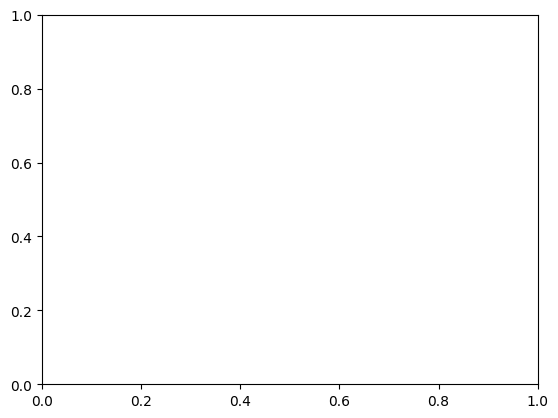

In [14]:
# Create a figure and axis for the plot
fig, ax = plt.subplots()
# use pyplot to visualise training curves
ax.plot(np.arange(1, epoch+2),train_metrics['train_loss'],'g--',label='training_loss')
ax.plot(np.arange(1, epoch+2),val_metrics['val_loss'],'r--',label='validation_loss')
ax.plot(np.arange(1, epoch+2),train_metrics['train_acc'],'g',label='training_accuracy')
ax.plot(np.arange(1, epoch+2),val_metrics['val_acc'],'r',label='validation_accuracy')
ax.set_title('Training and Validation Curves')
ax.set_xlabel('Epochs')
ax.set_ylabel('metrics')
ax.legend()
plt.show()